# Winsun Anlagen der Letzten 7 Tage


This Kernal shows how to connect to Impala in order to load data directly from HAL PROD or STAG.

It takes about 8 min to run the whole notebook.

## Import

More information about impyla see here: https://github.com/cloudera/impyla.

In [1]:
from impala.dbapi import connect 
from impala.util import as_pandas
import pandas as pd # For Data Handling
import numpy as np  # data processing, CSV file I/O (e.g. pd.read_csv)
import math as mt
import datetime as dt # To convert timestamp data
import matplotlib   #for plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
matplotlib.style.use('ggplot')
%matplotlib inline

## Day -7

In [2]:
today = dt.date.today()
week_ago = today - dt.timedelta(days=7)
epoch_last7 = week_ago.strftime('%s')

## Connect to DataHost wh-02 (172.16.10.102)
Querry benötigt ca. 45s + 39.29s für das refresh = 1.5 min

In [3]:
conn = connect(host='172.16.10.102', port=21050)
cur = conn.cursor()
cur.execute('refresh solarlog_roh')
cur.execute('SELECT `timestamp`,cur_yield_watt,plantname FROM solarlog_roh where `timestamp` > CAST('+epoch_last7+' AS INT) order by `timestamp` limit 100000')
dfp = as_pandas(cur)
cur.close()
conn.close()

In [4]:
print("Anzahl Zeilen geladen: " + str(len(dfp)))

Anzahl Zeilen geladen: 25402


In [5]:
dfp.head()

,timestamp,cur_yield_watt,plantname
0,1530050401,0,"Zengaffinen Hans, Steg"
1,1530050401,0,"Hugo Peter, Steg"
2,1530050401,0,"Seiler René, Steg"
3,1530050401,0,"Imboden Beat,Steg"
4,1530050401,0,"Himmelrichstrasse 1ab, Baar"


## Convert

In [6]:
# Change epochtime from timestamp to date time
dfp1 = pd.DataFrame() # New Data Frame
# Convert to datetime and add 1h corret time shift by collecting data
dfp1['datetime'] = dfp.timestamp.apply(dt.datetime.utcfromtimestamp) + pd.Timedelta(hours=1)
dfp1.sort_values(['datetime'])
dfp1['value_watt'] = dfp.cur_yield_watt
dfp1['name'] = dfp.plantname.astype('str') 

In [7]:
print("Neuste Daten von: \t\t" +  str(dfp1.datetime.max()))
print("Anzahl geladener Datensätze: \t" + str(len(dfp)))
print("Solaranlagen: \t\t\t" + str(len(dfp1.name.value_counts())))

Neuste Daten von: 		2018-07-04 10:00:01
Anzahl geladener Datensätze: 	25402
Solaranlagen: 			24


In [8]:
dfp1.name.value_counts()

Martig-Zenhäusern Ernestine, Steg       1060
Haller Roman, Rifferswil                1060
Seiler René, Steg                       1060
Pfadiheim Baar                          1060
Bregy Haustechnik AG, Steg              1059
Zengaffinen Hans, Steg                  1059
Baumgartu AG, Haus B                    1059
Garage Fryand AG, Steg                  1059
Loosmann Johannes, Hausen am Albis      1059
Baumgartu AG, Haus A, Steg              1059
Meyer Rolf, Baar                        1059
Zengaffinen Kurt, Steg                  1059
Bregy Bernhard, Steg                    1058
Mathieu Jörg, Steg                      1058
Betschart René, Steinhausen             1058
Winsun AG, Steg                         1058
Hugo Peter, Steg                        1058
Imboden Beat,Steg                       1058
Maechler Paul, Allenwinden              1058
Moser Robert,Steg                       1057
Heinzen Matthias und Christine, Steg    1057
Johner Daniel, Steg                     1057
Himmelrich

In [9]:
dfp1.info(verbose=False, buf=None, max_cols=False, memory_usage=True, null_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25402 entries, 0 to 25401
Columns: 3 entries, datetime to name
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 496.2+ KB


In [10]:
dfp1.groupby('name').describe().value_watt.head()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
"Baumgartu AG, Haus A, Steg",1059.0,11602.187913,12742.864064,0.0,0.0,2473.0,26328.50,32505.0
"Baumgartu AG, Haus B",1059.0,12909.357885,14176.351636,0.0,0.0,2590.0,29032.00,37646.0
"Betschart René, Steinhausen",1058.0,2703.738185,3182.579464,0.0,0.0,1010.5,5248.25,11172.0
"Bregy Bernhard, Steg",1058.0,2766.488658,3322.528329,0.0,0.0,557.0,6081.00,9589.0
"Bregy Haustechnik AG, Steg",1059.0,8011.490085,9215.064649,0.0,0.0,2137.0,17463.00,26217.0


Text(0.5,1,'Leistung geladener Winsun Anlagen')

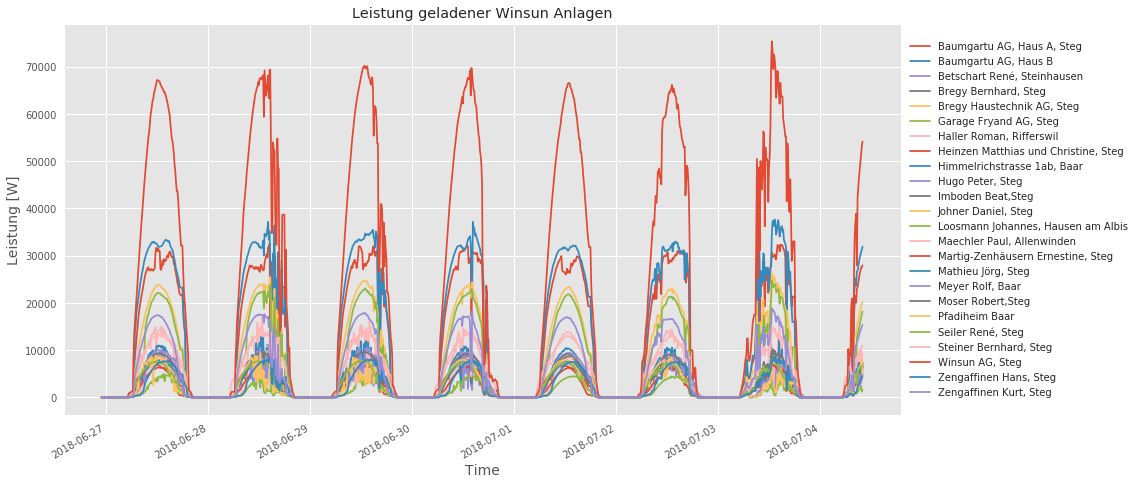

In [11]:
dfp1.set_index('datetime').groupby('name').value_watt.plot(figsize = (15,8));
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("Leistung [W]",size=14)
plt.xlabel("Time",size=14)
plt.title("Leistung geladener Winsun Anlagen")


In [12]:
today = dt.date.today()
week_ago = today - dt.timedelta(days=0)

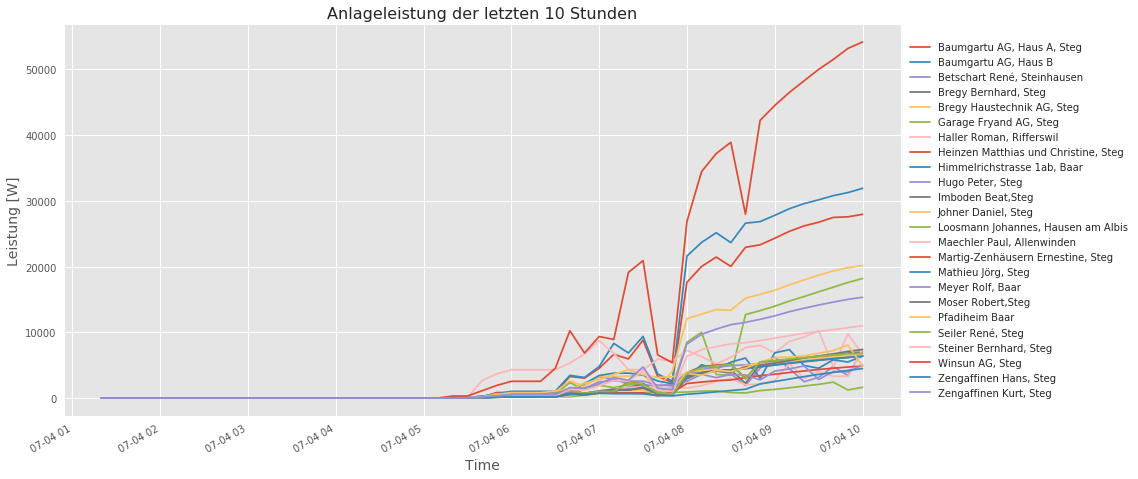

In [13]:
#Zeit Beschränkung
last_hour = dt.datetime.now() - dt.timedelta(hours = 10)
dfpt = dfp1[dfp1.datetime > last_hour]
#Plot
dfpt.set_index('datetime').groupby('name').value_watt.plot(figsize = (15,8));
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("Leistung [W]",size=14)
plt.xlabel("Time",size=14)
plt.title("Anlageleistung der letzten 10 Stunden", size=16)
plt.show()

In [14]:
df1 = dfp1[dfp1['name'] == 'Pfadiheim Baar'].copy()
df2 = dfp1[dfp1['name'] == 'Meyer Rolf, Baar'].copy()
df3 = dfp1[dfp1['name'] == 'Winsun AG, Steg'].copy()
df4 = dfp1[dfp1['name'] == 'Himmelrichstrasse 1ab, Baar'].copy()
df5 = dfp1[dfp1['name'] == 'Betschart René, Steinhausen'].copy()
df6 = dfp1[dfp1['name'] == 'Loosmann Johannes, Hausen am Albis'].copy()
df7 = dfp1[dfp1['name'] == 'Haller Roman, Rifferswil'].copy()
#df8 = dfp1[dfp1['name'] == 'Maechler Paul, Allenwinden']

## Detail Analyse (Region Zug)

In [15]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True) #need to use plotly offline

data = Data([Scatter(x=df1.datetime, y=df1.value_watt, name='Pfadiheim Baar'),
             Scatter(x=df2.datetime, y=df2.value_watt, name='Meyer Rolf, Baar'),
             Scatter(x=df3.datetime, y=df3.value_watt, name='Winsun AG, Steg'),
             Scatter(x=df4.datetime, y=df4.value_watt, name='Himmelrichstrasse 1ab, Baar'),
             Scatter(x=df5.datetime, y=df5.value_watt, name='Betschart René, Steinhausen'),
             Scatter(x=df6.datetime, y=df7.value_watt, name='Loosmann Johannes, Hausen am Albis'),
             Scatter(x=df7.datetime, y=df7.value_watt, name='Haller Roman, Rifferswil')])


layout = Layout(
    title='Leisungsverlauf über 7 Tage (Zug)',
    yaxis=dict(title='Leistung in [kW]'),
    xaxis=dict(title='Datum')
)

fig = Figure(data=data, layout=layout)

iplot(fig, filename = 'basic-line')

## Lade Solar Inventar Tabelle
Die Daten der Winsun Anlage in der inverntar_solar Tabelle werden direkt über die Solarlog API in HDFS konsumiert.

In [16]:
if False: # enable with True (not used at the moment)
    conn = connect(host='172.16.10.102', port=21050)
    cur = conn.cursor()
    cur.execute('refresh inventory_solar')
    cur.execute('SELECT * FROM inventory_solar')
    dfis = as_pandas(cur)
    cur.close()
    conn.close()
    #To see all tables tip only dfp without .head()
    dfis